In [10]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

import os

import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

import gphelper as gp
import ImageTools as it
import DataTools as dt

import importlib

/home/ryanhausen/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:339: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


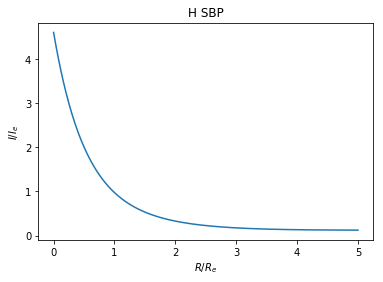

In [2]:
X = np.linspace(0.001, 5, 500)[:, np.newaxis]
h_model = gp.GPHelper(restore_file='./gp-models/gp_h.json')
y_gp = 10**h_model.sample(X)

plt.title('H SBP')
plt.ylabel('$I/I_e$')
plt.xlabel('$R/R_e$')
plt.plot(X, y_gp)
plt.show()

In [14]:
def sbp_to_int(x, y):
    delta_x = np.diff(x)[0]/2
    xs = [np.pi*((_x+delta_x)**2-(_x-delta_x)**2) for _x in x.flatten()]
    xs = np.array(xs)
    
    weighted_y = xs * y
    I_tot = weighted_y.sum()
    int_I = np.cumsum(weighted_y/I_tot)
    return int_I, I_tot, xs

def img_sbp_to_int(x, y, Itot=None):
    I_tot = Itot if Itot else y.sum()
    I_int = np.cumsum(y/I_tot)
    
    return I_int

def int_to_sbp(x, y, y_tot):
    return (np.array([0] + np.diff(y).tolist())*y_tot)/x

def eta_line(x, difference_at_1):
    def delta_l(x, diff):
        return diff - diff * (1-x)**2
    
    def delta_r(x, diff):
        return diff - diff * ((x-1)/(x.max()-1))**2
    
    eta = np.zeros_like(x)
    eta[x<=1] = delta_l(x[x<=1], difference_at_1)
    eta[x>1] = delta_r(x[x>1], difference_at_1)

    return eta

# https://ned.ipac.caltech.edu/level5/March05/Graham/Graham2.html
def sersic(x):
    def b(n):
        return 1.9992*n-0.3271

    def I(r):
        """Assuming that I_e=1.0 and that R_e=1.0"""
        n = 4
        return np.exp(-b(n) * (np.power(r, 1/n)  - 1))

    return I(x)

def get_random_spheroids(num=10):
    with open('../spheroids', 'r') as f:
        spheroids = np.array(f.readlines())
        
    selected = np.random.choice(spheroids, num, replace=False)
    
    data_dir = os.path.join(os.getenv('HOME'), 'Documents/astro_data/orig_images')
    fmask = 'GDS_{}_{}.fits'
    f_string = os.path.join(data_dir, fmask)
    
    sources = []
    for s in selected:
        img = fits.getdata(f_string.format(s.strip(), 'h'))
        segmap = fits.getdata(f_string.format(s.strip(), 'segmap'))
        img_id = int(s.split('_')[1])
        sources.append((img, segmap, img_id))
    
    return sources

def make_nonnegative(img):
    epsilon = 0 if len(img[img<0])==0 else img[img>0].min()
    return img + abs(img.min()) + epsilon

In [31]:
importlib.reload(it)

y_gp_int, I_tot, wx = sbp_to_int(X.flatten(), y_gp.flatten())
diff_at_1 = 0.5-y_gp_int[np.square(X-1).argmin()]
y_gp_eta = y_gp_int + eta_line(X.flatten(), diff_at_1)

sources = []
for img, segmap, img_id in get_random_spheroids():
    img = make_nonnegative(img)
    rs, fs, ie, re, Itot = iterative_profile_expansion(img, segmap, img_id)
    sources.append((rs, fs, re, ie, Itot))

X_sersic = np.linspace(0.001, 50, 5000)[:, np.newaxis]
y_sersic = sersic(X_sersic)
y_sersic_int, _, _ = sbp_to_int(X_sersic.flatten(), y_sersic.flatten())

plt.figure(figsize=(15, 10))
plt.title('Measured SBP')
plt.xlabel('$R/R_e$')
plt.ylabel('$I/I_e$')
plt.xlim((0,5))

plt.semilogy(X, y_gp, label='GP')
plt.semilogy(X_sersic, y_sersic, label='Sersic')

for x, y, r, i, itot in sources:
    plt.semilogy(x/r, y/i, '--', alpha=0.3)
plt.legend()
    
plt.figure(figsize=(15, 10))
plt.title('Measured Integrations')
plt.xlabel('$R/R_e$')
plt.xlim((0,5))

plt.plot(X, y_gp_int, label='GP')
plt.plot(X, y_gp_eta, label='GP+eta')
plt.plot(X_sersic, y_sersic_int, label='Sersic')

for x, y, r, i, itot in sources:
    s_int = img_sbp_to_int(x.flatten(), y, Itot=itot)
    plt.plot(x/r, s_int, '--', alpha=0.5)
m = max([max(s[0]) for s in sources])
plt.legend()
    
plt.show()
    
plt.figure(figsize=(15, 10))
plt.title('Measured Integrations')
plt.xlabel('$R/R_e$')
plt.xlim((0,5))

plt.plot(X, y_gp_int, label='GP')
plt.plot(X, y_gp_eta, label='GP+eta')
plt.plot(X_sersic, y_sersic_int, label='Sersic')

plt.ylim(0,1)
for x, y, r, i, itot in sources:
    s_int = img_sbp_to_int(x.flatten(), y, Itot=itot)
    plt.plot(x/r, s_int, '--', alpha=0.5)
m = max([max(s[0]) for s in sources])
plt.legend()

plt.show()

Initial re:4.340425550640099
Found re:13.139115849729702
Found re:32.29136834772319
Found re:36.33160100595017
Found re:40.39280516265671
Found re:44.5678515859206
Found re:48.51110678333907
Found re:52.58585173185788
Found re:56.64367862033278
Found re:60.72062615710414
Found re:64.80492059849794
Found re:68.7935632461957
Found re:72.965756145396
Found re:76.95935430582986
Found re:80.99300472226676
Found re:85.04147824076894
Found re:89.12969899269152
Found re:93.11723494605458
Found re:97.137733100401
Found re:101.1680917933817
Found re:105.22341625214666
Found re:109.26547131450748
Found re:113.26870051708977
Found re:117.34646581475329
Found re:121.33376578216077
Found re:125.35656826498247
Found re:129.4135332431169
Found re:133.4594849887468
Found re:137.4816460909533
Found re:141.45082372249644
Found re:145.41434368610354
Found re:149.33677069783135
Found re:153.31211642798914
Found re:157.27094259411
Found re:161.2331907395052
Found re:165.23519433217618
Found re:169.211211005

KeyboardInterrupt: 

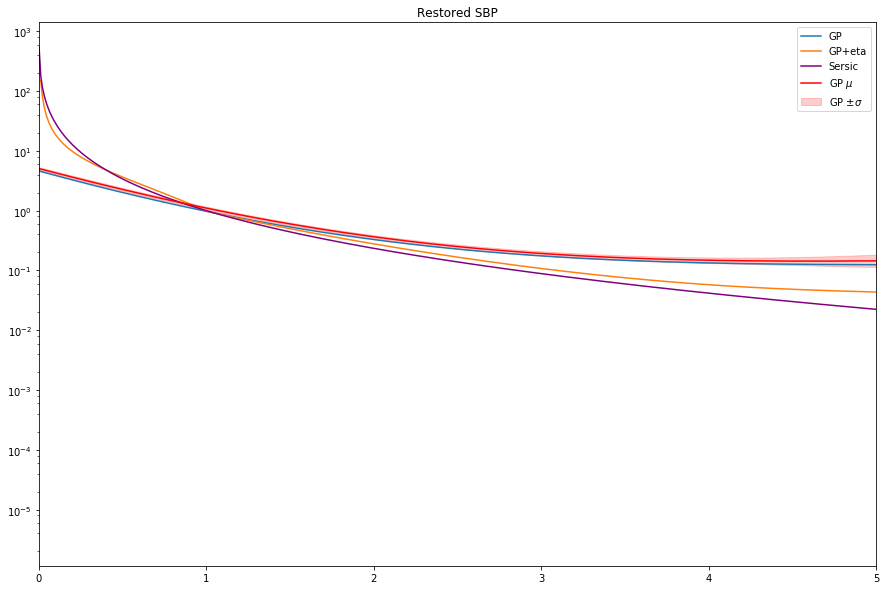

In [14]:
y_mean, y_std = h_model.predict(X, return_std=True)
y_pls_std = 10**(y_mean + y_std)
y_min_std = 10**(y_mean - y_std)
y_mean =  10 **y_mean

restored_gp_eta = int_to_sbp(wx, y_gp_eta, I_tot)
restored_gp = int_to_sbp(wx, y_gp_int.flatten(), I_tot)

plt.figure(figsize=(15, 10))
plt.title('Restored SBP')
plt.semilogy(X, y_gp, label='GP')
plt.semilogy(X, restored_gp_eta, label='GP+eta')
plt.semilogy(X_sersic, y_sersic, label='Sersic', color='purple')
plt.semilogy(X, y_mean, label='GP $\mu$', color='r')
plt.fill_between(X.flatten(), y_min_std, y_pls_std, label='GP $\pm\sigma$', alpha=0.2, color='r')
plt.xlim(0,5)
plt.legend()
plt.show()

In [6]:
a = np.arange(9).reshape(3,3)
np.pad(a, 3, 'constant')

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 2, 0, 0, 0],
       [0, 0, 0, 3, 4, 5, 0, 0, 0],
       [0, 0, 0, 6, 7, 8, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [29]:
def get_re(img, src_map, rs):
    Itot = img[src_map].sum()
    
    rs = rs[src_map]
    fs = img[src_map]

    sorted_rs = np.argsort(rs)
    int_fs = np.cumsum(fs[sorted_rs]/Itot)
    re_idx = np.square(int_fs-0.5).argmin()

    rs = rs[sorted_rs]
    fs = fs[sorted_rs]

    return rs[re_idx]

def iterative_profile_expansion(img, segmap, img_id, out_to=5):
    # strip other sources from image
    noise_bank = img[segmap==0].flatten()
    
    other_sources = np.logical_and(segmap!=0, segmap!=img_id)
    if other_sources.sum() > 0:
        np.place(img, other_sources, noise_bank)
    
    # get re
    src_map = segmap==img_id
    cx, cy = it.img_center(img, src_map)
    xs, ys = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]).T)
    rs = np.sqrt(np.square(cx-xs) + np.square(cy-ys))
    re = get_re(img, src_map, rs)
    _re = 0
    
    print(f'Initial re:{re}')
    while re != _re:
        src_map = np.logical_or(src_map, (rs<=(5*re)))
        if np.all(src_map):
            # the src_map taken the entire image
            img = np.pad(img, 5, 'constant')
            np.place(img, img==0, noise_bank)
            src_map = np.pad(src_map, 5, 'constant')
            cx, cy = cx+5, cy+5
            xs, ys = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]).T)
            rs = np.sqrt(np.square(cx-xs) + np.square(cy-ys))
            
        
        _re = re
        re = get_re(img, src_map, rs)
        print(f'Found re:{re}')
    rs, fs, ie, re = it.rs_fs_ie_re(img, src_map)
    
    return rs, fs, ie, re, img[src_map].sum()
    
    
    
    
    
    
    
    
    
    

In [28]:
img, segmap, img_id = get_random_spheroids(num=1)[0]


iterative_profile_expansion(img, segmap, img_id)

Initial re:3.5443516014972163
Found re:3.8494673903512546
Found re:3.892807696152707
Found re:3.903015938313854
Found re:3.903015938313854


(array([  0.36345977,   0.67256004,   0.93517724, ...,  19.47742812,
         19.49747538,  19.50865213]),
 array([ 1.437356  ,  1.39618278,  1.07785511, ...,  0.00247395,
         0.00417994,  0.00304228], dtype=float32),
 0.24367458,
 3.9069520859284421,
 52.48381)